# Permit Type Classification Final Model Training

## Description


 The purpose of this model is classify construction permit types into four categories given a string input of the permit description or any notes regarding the permit. The four categories are electrical, building, mechanical, and plumbing. The core of the model is the BERT deep learning model developed by Google. 

## Data 

The data used for training were collected from three cities in the United States sourcing from public city records. The cities are Boston, Austin, and San Francisco. The raw permit data have been normalized to fit within one of the four labels. For example, the Boston dataset originally contained 14 permit classes. Those classes are mapped to the four categories eletrical, building, mechanical, and plumbing. The original datasets are additionally processed to remove incomplete data points. Only the permit description are used to train the model. 


## Training

In [1]:
import os
import shutil

import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text

from official.nlp import optimization

import matplotlib.pyplot as plt
print('Tensorflow version: ', tf.__version__)
print('GPU available: ', tf.config.list_physical_devices('GPU'))

Tensorflow version:  2.6.0
GPU available:  [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [2]:
### data ###
data_dir = "training_v5"
train_dir = os.path.join(data_dir, 'train')
test_dir = os.path.join(data_dir, 'test')

In [3]:
### data reorganization ###
AUTOTUNE = tf.data.AUTOTUNE
batch_size = 64
seed = 42

raw_train_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='training',
    seed=seed)

class_names = raw_train_ds.class_names
train_ds = raw_train_ds.cache().prefetch(buffer_size=AUTOTUNE)

val_ds = tf.keras.preprocessing.text_dataset_from_directory(
    train_dir,
    batch_size=batch_size,
    validation_split=0.2,
    subset='validation',
    seed=seed)

val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

test_ds = tf.keras.preprocessing.text_dataset_from_directory(
    test_dir,
    batch_size=batch_size)

test_ds = test_ds.cache().prefetch(buffer_size=AUTOTUNE)

Found 4103056 files belonging to 2 classes.
Using 3282445 files for training.
Found 4103056 files belonging to 2 classes.
Using 820611 files for validation.
Found 216180 files belonging to 2 classes.


In [4]:
### viewing sample data ###
for text_batch, label_batch in train_ds.take(1):
  for i in range(3):
    print(f'Description: {text_batch.numpy()[i]}')
    label = label_batch.numpy()[i]
    print(f'Label : {label} ({class_names[label]})')

Description: b'reroofing'
Label : 1 (pre_construction)
Description: b'renew pa# 2003/05/15/4759 to obtain final inspection. all work is completed.'
Label : 1 (pre_construction)
Description: b'New Res'
Label : 0 (post_construction)


In [5]:
### BERT model ###
bert_model_name = 'small_bert/bert_en_uncased_L-4_H-512_A-8'
model_encoder = 'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1'
model_preprocess = 'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3'

In [6]:
bert_preprocess_model = hub.KerasLayer(model_preprocess)

In [7]:
bert_model = hub.KerasLayer(model_encoder)

In [8]:
### Building classifier ###
def build_classifier_model():
  text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
  preprocessing_layer = hub.KerasLayer(model_preprocess, name='preprocessing')
  encoder_inputs = preprocessing_layer(text_input)
  encoder = hub.KerasLayer(model_encoder, trainable=True, name='BERT_encoder')
  outputs = encoder(encoder_inputs)
  net = outputs['pooled_output']
  net = tf.keras.layers.Dropout(0.1)(net)
  net = tf.keras.layers.Dense(1, activation=tf.nn.sigmoid, name='classifier')(net)
  return tf.keras.Model(text_input, net)

classifier_model = build_classifier_model()

In [9]:
### Train the model ###

checkpoint_path = "checkpoints_bin/cp.ckpt"
checkpoint_dir = os.path.dirname(checkpoint_path)
cp_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                 save_weights_only=True,
                                                 verbose=1)

loss = tf.keras.losses.BinaryCrossentropy(from_logits=True)
metrics = tf.metrics.BinaryAccuracy()
epochs = 2
steps_per_epoch = tf.data.experimental.cardinality(train_ds).numpy()
num_train_steps = steps_per_epoch * epochs
num_warmup_steps = int(0.1*num_train_steps)

init_lr = 3e-5
optimizer = optimization.create_optimizer(init_lr=init_lr,
                                          num_train_steps=num_train_steps,
                                          num_warmup_steps=num_warmup_steps,
                                          optimizer_type='adamw')
classifier_model.compile(optimizer=optimizer,
                         loss=loss,
                         metrics=metrics)

print(f'Training model with {model_encoder}')
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=epochs, callbacks=[cp_callback])

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-4_H-512_A-8/1
Epoch 1/2
51289/51289 [==============================] - 28968s 565ms/step - loss: 0.5760 - binary_accuracy: 0.8656 - val_loss: 0.5691 - val_binary_accuracy: 0.8806

Epoch 00001: saving model to checkpoints_bin\cp.ckpt
Epoch 2/2
51289/51289 [==============================] - 27794s 542ms/step - loss: 0.5681 - binary_accuracy: 0.8822 - val_loss: 0.5673 - val_binary_accuracy: 0.8841

Epoch 00002: saving model to checkpoints_bin\cp.ckpt


3378/3378 [==============================] - 1137s 337ms/step - loss: 0.5675 - binary_accuracy: 0.8845
Loss: 0.5675368309020996
Accuracy: 0.8844666481018066
dict_keys(['loss', 'binary_accuracy', 'val_loss', 'val_binary_accuracy'])


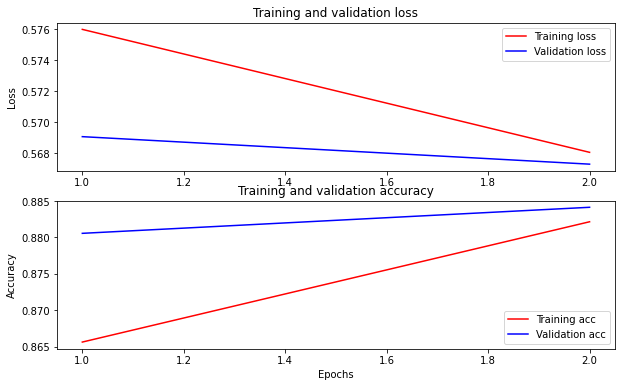

In [11]:
### Model evaluation ###

loss, accuracy = classifier_model.evaluate(test_ds)

print(f'Loss: {loss}')
print(f'Accuracy: {accuracy}')

history_dict = history.history
print(history_dict.keys())

acc = history_dict['binary_accuracy']
val_acc = history_dict['val_binary_accuracy']
loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(acc) + 1)
fig = plt.figure(figsize=(10, 6))
fig.tight_layout()

plt.subplot(2, 1, 1)
# r is for "solid red line"
plt.plot(epochs, loss, 'r', label='Training loss')
# b is for "solid blue line"
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
# plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(2, 1, 2)
plt.plot(epochs, acc, 'r', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')

In [12]:
### Save the model ###

dataset_name = 'final_ds'
saved_model_path = './{}_modelv2_bin'.format(dataset_name.replace('/', '_'))

classifier_model.save(saved_model_path)

INFO:tensorflow:Assets written to: ./final_ds_modelv2_bin\assets


INFO:tensorflow:Assets written to: ./final_ds_modelv2_bin\assets


In [13]:
### Reload model ###

reloaded_model = tf.saved_model.load(saved_model_path)

In [14]:
### Test results ###

import numpy as np

def print_my_examples(inputs, results):
  result_for_printing = \
    [f'input: {inputs[i]:<30} : score: {results[i][0]:.6f}'
                         for i in range(len(inputs))]
  print(*result_for_printing, sep='\n')
  print()


examples = [
    'work for Blue Bottle Cafe RTU connection',
    'Install toilet  sink  lavs  shower  laundry and water heater.',
    'Residential Parking,use of premises for;1 car parking with new driveway  eplan',
    'Low Voltage,To install an intercom door bell system and security camera in the buildingTo install TV cable  in all three floor',
    'Relocate existing smoke detectors and horn/strobes. Install additional smoke detectors and horn/strobes for new 5th. floor office lay-out.'
]

# reloaded_results = reloaded_model(tf.constant(examples))
original_results = classifier_model(tf.constant(examples))
print(class_names)
print(original_results)
print('Results:')
max_ind = np.argmax(original_results.numpy(), axis=1)
for idx in max_ind:
    print('\t',class_names[idx])


['post_construction', 'pre_construction']
tf.Tensor(
[[4.8769505e-07]
 [4.3910998e-07]
 [9.9999964e-01]
 [6.4729471e-07]
 [1.1835682e-06]], shape=(5, 1), dtype=float32)
Results:
	 post_construction
	 post_construction
	 post_construction
	 post_construction
	 post_construction


In [16]:
history = classifier_model.fit(x=train_ds,
                               validation_data=val_ds,
                               epochs=2, callbacks=[cp_callback])

Epoch 1/2
51289/51289 [==============================] - 27678s 540ms/step - loss: 0.5669 - binary_accuracy: 0.8844 - val_loss: 0.5673 - val_binary_accuracy: 0.8841

Epoch 00001: saving model to checkpoints_bin\cp.ckpt
Epoch 2/2
51289/51289 [==============================] - 26919s 525ms/step - loss: 0.5669 - binary_accuracy: 0.8846 - val_loss: 0.5673 - val_binary_accuracy: 0.8841

Epoch 00002: saving model to checkpoints_bin\cp.ckpt


In [17]:
loss, accuracy = classifier_model.evaluate(test_ds)
classifier_model.save(saved_model_path)

3378/3378 [==============================] - 1126s 333ms/step - loss: 0.5675 - binary_accuracy: 0.8845


INFO:tensorflow:Assets written to: ./final_ds_modelv2_bin\assets


INFO:tensorflow:Assets written to: ./final_ds_modelv2_bin\assets
